In [1]:
import genemunge
import json
import matplotlib
%matplotlib inline

# Searching for genes 

In [2]:
# set up an object to search the gene ontology
searcher = genemunge.search.Searcher()

# get all of the GO categories associated with the word 'immune'
# set exact = False to walk through the ontology and grab all child terms
immune_categories = searcher.keyword_search(['immune'], exact=False)

# get all of the genes assigned to the immune_categories
immune_genes = searcher.get_genes(immune_categories)

# get a list of housekeeping genes
housekeeping = searcher.get_housekeeping_genes()

print(housekeeping)

# keep all of the immune related genes that are not housekeeping genes
variable_immune_genes = list(set(immune_genes) - set(housekeeping))

print('Identified {} variable immune related genes'.format(len(variable_immune_genes)))

['ENSG00000000419', 'ENSG00000000457', 'ENSG00000001084', 'ENSG00000002330', 'ENSG00000002549', 'ENSG00000003056', 'ENSG00000003393', 'ENSG00000003756', 'ENSG00000004059', 'ENSG00000004142', 'ENSG00000004455', 'ENSG00000004534', 'ENSG00000004866', 'ENSG00000004897', 'ENSG00000004961', 'ENSG00000005007', 'ENSG00000005022', 'ENSG00000005075', 'ENSG00000005100', 'ENSG00000005156', 'ENSG00000005175', 'ENSG00000005206', 'ENSG00000005302', 'ENSG00000005700', 'ENSG00000005801', 'ENSG00000005812', 'ENSG00000005882', 'ENSG00000005893', 'ENSG00000006007', 'ENSG00000006451', 'ENSG00000006625', 'ENSG00000006652', 'ENSG00000006712', 'ENSG00000006744', 'ENSG00000006831', 'ENSG00000007047', 'ENSG00000007080', 'ENSG00000007168', 'ENSG00000007202', 'ENSG00000007520', 'ENSG00000007923', 'ENSG00000008018', 'ENSG00000008282', 'ENSG00000008294', 'ENSG00000008324', 'ENSG00000008382', 'ENSG00000008838', 'ENSG00000008952', 'ENSG00000009335', 'ENSG00000009844', 'ENSG00000009954', 'ENSG00000010165', 'ENSG000000

# Converting between identifier types

In [3]:
# set up an object to convert from ensembl to symbol
ensembl_to_symbol = genemunge.convert.IDConverter('ensembl_gene_id', 'symbol')

# convert the immune identifiers to gene symbols
variable_immune_symbols = ensembl_to_symbol.convert_list(variable_immune_genes)

# Getting information about a specific gene

{
  "ensembl": "ENSG00000211891",
  "symbol": "IGHE",
  "name": "immunoglobulin heavy constant epsilon",
  "ontology": {
    "GO:0006955": "immune response",
    "GO:0038095": "Fc-epsilon receptor signaling pathway",
    "GO:0050871": "positive regulation of B cell activation",
    "GO:0005576": "extracellular region",
    "GO:0003823": "antigen binding",
    "GO:0045087": "innate immune response",
    "GO:0006911": "phagocytosis, engulfment",
    "GO:0034987": "immunoglobulin receptor binding",
    "GO:0050853": "B cell receptor signaling pathway",
    "GO:0006958": "complement activation, classical pathway",
    "GO:0006910": "phagocytosis, recognition",
    "GO:0072562": "blood microparticle",
    "GO:0019221": "cytokine-mediated signaling pathway",
    "GO:0042742": "defense response to bacterium",
    "GO:0042571": "immunoglobulin complex, circulating",
    "GO:0009897": "external side of plasma membrane"
  }
}


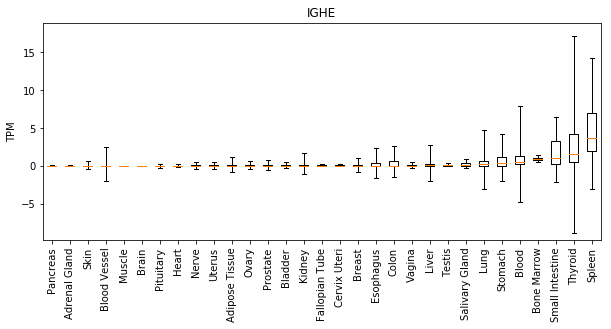

In [4]:
# set up an object to describe genes
describer = genemunge.describe.Describer('symbol')

# get some basic information about one of the immune genes
print(json.dumps(describer.get_gene_info(variable_immune_symbols[0]), indent=2))

# make a plot of the expression of one of the immune genes across tissues from GTEx
describer.plot_tissue_expression(variable_immune_symbols[0], sortby='median')